<a href="https://colab.research.google.com/github/shivani-202/semantic-scene-classification/blob/main/ms-coco_assignment05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT KAGGLE DATA SOURCES,
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY COLAB
# NOTEBOOK.
import kagglehub
awsaf49_coco_2017_dataset_path = kagglehub.dataset_download('awsaf49/coco-2017-dataset')
xinleili_nuswide_path = kagglehub.dataset_download('xinleili/nuswide')
gopalbhattrai_pascal_voc_2012_dataset_path = kagglehub.dataset_download('gopalbhattrai/pascal-voc-2012-dataset')

print('Data source import complete.')


In [ ]:
!pip install torch torchvision torchaudio
!pip install numpy pandas matplotlib seaborn scikit-learn opencv-python wandb
!pip install albumentations
!pip install transformers timm


In [ ]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")
wandb.login(key = secret_value_0)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 21dcs028 (21dcs028-national-institute-of-technology-hamirpur). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

*Load datasets :*
* MS COCO
* PASCAL VOC
* NUS-WIDE
* VISUAL GENOME

loading annotations into memory...
Done (t=15.38s)
creating index...
index created!


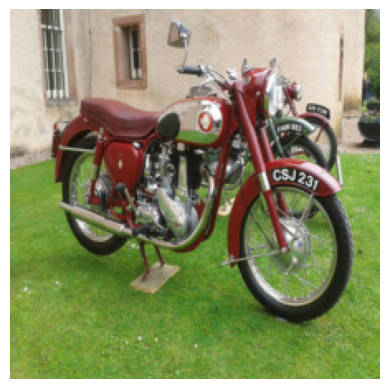

Labels: [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
from pycocotools.coco import COCO
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

class COCODataset(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None, fraction=1.0):
        self.coco = COCO(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.img_ids = list(self.coco.imgs.keys())

        # Reduce dataset to a fraction of the original
        num_samples = int(len(self.img_ids) * fraction)
        self.img_ids = random.sample(self.img_ids, num_samples)

        # Get COCO category IDs and map them to a continuous range [0, 79]
        self.cat_id_to_contiguous = {cat_id: i for i, cat_id in enumerate(self.coco.getCatIds())}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        labels = torch.zeros(80)  # 80 COCO classes

        for ann in anns:
            cat_id = ann['category_id']
            if cat_id in self.cat_id_to_contiguous:
                labels[self.cat_id_to_contiguous[cat_id]] = 1  # Map category ID to [0, 79]

        if self.transform:
            img = self.transform(img)

        return img, labels


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


coco_dataset = COCODataset(
    img_dir="/kaggle/input/coco-2017-dataset/coco2017/train2017",
    annotation_file="/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json",
    transform=transform,
    fraction=0.2
)

train_loader = DataLoader(coco_dataset, batch_size=16, shuffle=True)


dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    img = img * 255  # Scale back to [0, 255]
    plt.imshow(img.astype(np.uint8))
    plt.axis("off")  # Hide axes
    plt.show()


imshow(images[0])
print("Labels:", labels[0].numpy())  # corresponding multi-labels


loading annotations into memory...
Done (t=18.06s)
creating index...
index created!


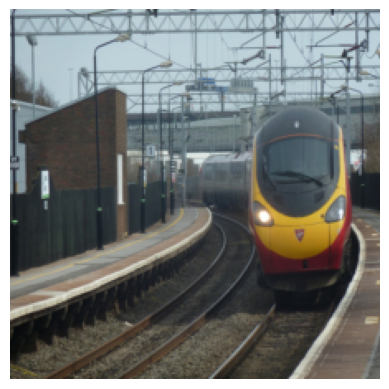

Labels: [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
import os
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO

class SceneDataset(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None, fraction=1.0):
        self.coco = COCO(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.img_ids = list(self.coco.imgs.keys())

        # Reduce dataset size for quicker training
        num_samples = int(len(self.img_ids) * fraction)
        self.img_ids = random.sample(self.img_ids, num_samples)

        # Use COCO "stuff" categories (scene context)
        self.cat_id_to_contiguous = {cat_id: i for i, cat_id in enumerate(self.coco.getCatIds())}
        self.num_classes = len(self.cat_id_to_contiguous)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Multi-label scene classification
        labels = torch.zeros(len(self.cat_id_to_contiguous))  # Scene categories

        for ann in anns:
            cat_id = ann['category_id']
            if cat_id in self.cat_id_to_contiguous:
                labels[self.cat_id_to_contiguous[cat_id]] = 1  # Multi-label classification

        if self.transform:
            img = self.transform(img)

        return img, labels

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
coco_dataset = SceneDataset(
    img_dir="/kaggle/input/coco-2017-dataset/coco2017/train2017",
    annotation_file="/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json",
    transform=transform,
    fraction=0.2  # Use a subset of data for faster training
)

# DataLoader
train_loader = DataLoader(coco_dataset, batch_size=16, shuffle=True)

# Visualize data
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    img = img * 255  # Scaling back to [0, 255]
    plt.imshow(img.astype(np.uint8))
    plt.axis("off")  # Hide axes
    plt.show()

imshow(images[0])
print("Labels:", labels[0].numpy())  # Multi-label scene classification output


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
class SceneDataset(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None, fraction=1.0):
        self.coco = COCO(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.img_ids = list(self.coco.imgs.keys())

        # Reduce dataset size for quicker training
        num_samples = int(len(self.img_ids) * fraction)
        self.img_ids = random.sample(self.img_ids, num_samples)

        # Scene category mapping
        self.cat_id_to_contiguous = {cat_id: i for i, cat_id in enumerate(self.coco.getCatIds())}
        self.num_classes = len(self.cat_id_to_contiguous)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        labels = torch.zeros(self.num_classes)  # Multi-label setup

        for ann in anns:
            cat_id = ann['category_id']
            if cat_id in self.cat_id_to_contiguous:
                labels[self.cat_id_to_contiguous[cat_id]] = 1

        if self.transform:
            img = self.transform(img)

        return img, labels



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


train_dataset = SceneDataset(
    img_dir="/kaggle/input/coco-2017-dataset/coco2017/train2017",
    annotation_file="/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json",
    transform=transform,
    fraction=0.2
)

test_dataset = SceneDataset(
    img_dir="/kaggle/input/coco-2017-dataset/coco2017/val2017",
    annotation_file="/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json",
    transform=transform,
    fraction=0.2
)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

loading annotations into memory...
Done (t=19.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [ ]:
import os
import random
import torch
import timm
import wandb
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pycocotools.coco import COCO
from sklearn.metrics import (
    accuracy_score, hamming_loss, precision_recall_fscore_support,
    jaccard_score, average_precision_score, multilabel_confusion_matrix
)

# Initialize WandB
wandb.init(project="multi-label-ensemble")

# Model Choices for ms-coco
model_names = ["vgg16", "resnet18", "densenet121", "googlenet"]

# Hyperparameters
hyperparams = {
    "learning_rate": 1e-4,
    "batch_size": 8,
    "epochs": 5,
    "optimizer": "AdamW",
    "dropout": 0.5
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




class SceneModel(nn.Module):
    def __init__(self, base_model, num_classes = 80, dropout_rate=0.5):
        super(SceneModel, self).__init__()
        self.model = timm.create_model(base_model, pretrained=True)

        # Apply dropout
        self.dropout = nn.Dropout(dropout_rate)


        if hasattr(self.model, 'fc'):  # ResNet
            in_features = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Flatten(),
                self.dropout,
                nn.Linear(in_features, num_classes)
            )
        elif hasattr(self.model, 'classifier'):  # VGG, DenseNet, AlexNet
            if isinstance(self.model.classifier, nn.Sequential):
                in_features = self.model.classifier[-1].in_features
                self.model.classifier = nn.Sequential(
                    nn.Flatten(),
                    self.dropout,
                    nn.Linear(in_features, num_classes)
                )
            else:
                in_features = self.model.classifier.in_features
                self.model.classifier = nn.Sequential(
                    nn.Flatten(),
                    self.dropout,
                    nn.Linear(in_features, num_classes)
                )
        elif hasattr(self.model, 'head'):  # Vision Transformers (ViTs)
            in_features = self.model.head.in_features
            self.model.head = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features, num_classes)
            )

    def forward(self, x):
        return self.model(x)






def train(model, optimizer, criterion, dataloader, epochs=5):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch + 1, "loss": avg_loss})
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Threshold for multi-label classification

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    return all_preds, all_labels


trained_models = []
for model_name in model_names:
    print(f"Training {model_name}...")

    model = SceneModel(model_name, num_classes=train_dataset.num_classes, dropout_rate=hyperparams["dropout"])
    optimizer = optim.Adam(model.parameters(), lr=hyperparams["learning_rate"])
    criterion = nn.BCEWithLogitsLoss()

    train(model, optimizer, criterion, train_loader, epochs=hyperparams["epochs"])
    trained_models.append(model)

    print(f"Finished training {model_name}.")



def ensemble_prediction(models, dataloader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.cpu().numpy()
            model_preds = []

            for model in models:
                model.to(device)
                model.eval()
                outputs = model(images)
                preds = torch.sigmoid(outputs).cpu().numpy()
                model_preds.append(preds)

            avg_preds = np.mean(model_preds, axis=0)
            final_preds = (avg_preds > 0.5).astype(int)

            all_preds.append(final_preds)
            all_labels.append(labels)

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)


    acc = accuracy_score(all_labels, all_preds)
    f1 = precision_recall_fscore_support(all_labels, all_preds, average="micro")[2]
    jaccard = jaccard_score(all_labels, all_preds, average="micro")

    print(f"Ensemble - Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Jaccard Index: {jaccard:.4f}")
    wandb.log({"ensemble_accuracy": acc, "ensemble_f1": f1, "ensemble_jaccard": jaccard})

    return all_preds, all_labels



ensemble_preds, ensemble_labels = ensemble_prediction(trained_models, test_loader)



Training vgg16...
Epoch [1/5], Loss: 0.1045
